In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from modules.process_data import mapping1, mapping2
from modules.utils import *

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-31 12:37:05.321438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 12:37:05.884970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
!python "modules/train_script_scd.py" 128 10 0.0001 5 0 mlp -s_layers 4096 2048 1024 512 256 128 64 32

2024-05-31 12:56:18.743613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 12:56:19.273541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Number of pairs: 5
Batch_size: 128
Learning rate: 0.0001
Epochs: 10
Split: 0
Tag: mlp
Hidden layers: [4096, 2048, 1024, 512, 256, 128, 64, 32]
100%|█████████████████████████████████████████| 603/603 [00:23<00:00, 25.22it/s]
Epoch 0, Train Loss: 0.21414300237178407, Validation Accuracy: 0.7680663557173737
Model saved as best model
100%|█████████████████████████████████████████| 603/603 [00:23<00:00, 25.62it/s]
Epoch 1, Train Loss: 0.10102153814723638, Validation Accuracy: 0.7807153967948328
Model saved as best model
100%|██████████████████████████████████████

In [9]:
!python "modules/eval_script _scd.py" mlp mlp_0_5_32.pth 0 -s_layers 4096 2048 1024 512 256 128 64 32

2024-05-31 13:02:35.692377: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 13:02:36.226491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|██████████████████████████████████████| 3858/3858 [00:08<00:00, 457.33it/s]


In [10]:
X, Y = pickle.load(open('embed_mlp_0_5_32.pth.pkl', 'rb'))

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


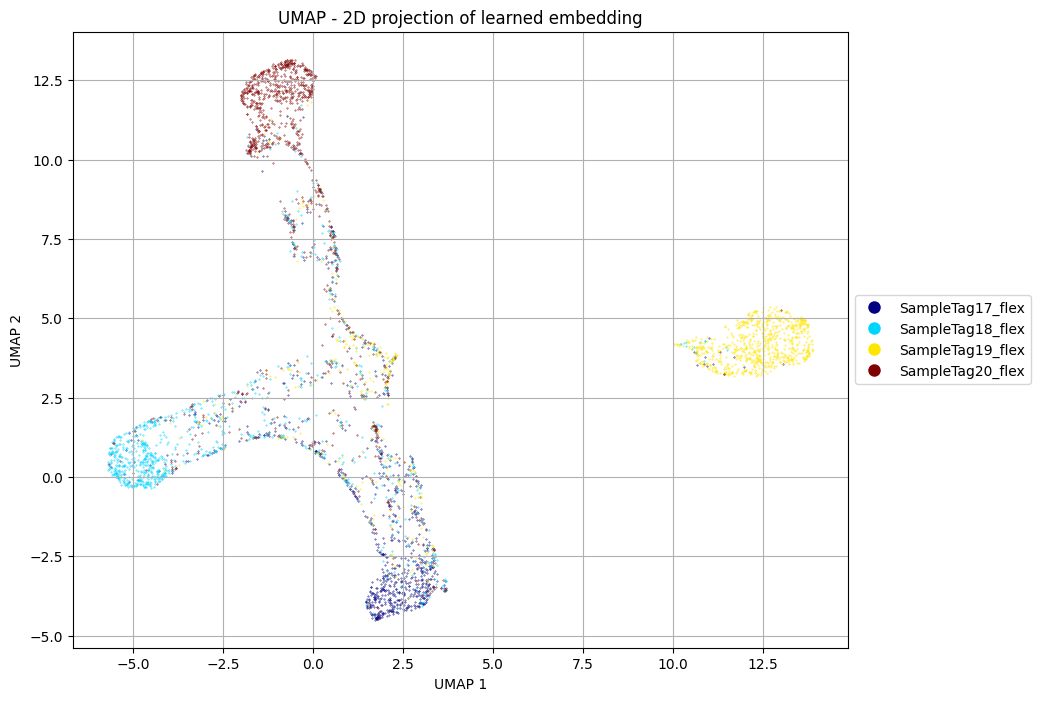

In [11]:
get_umap(X, Y, "mlp_umap", mapping2)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


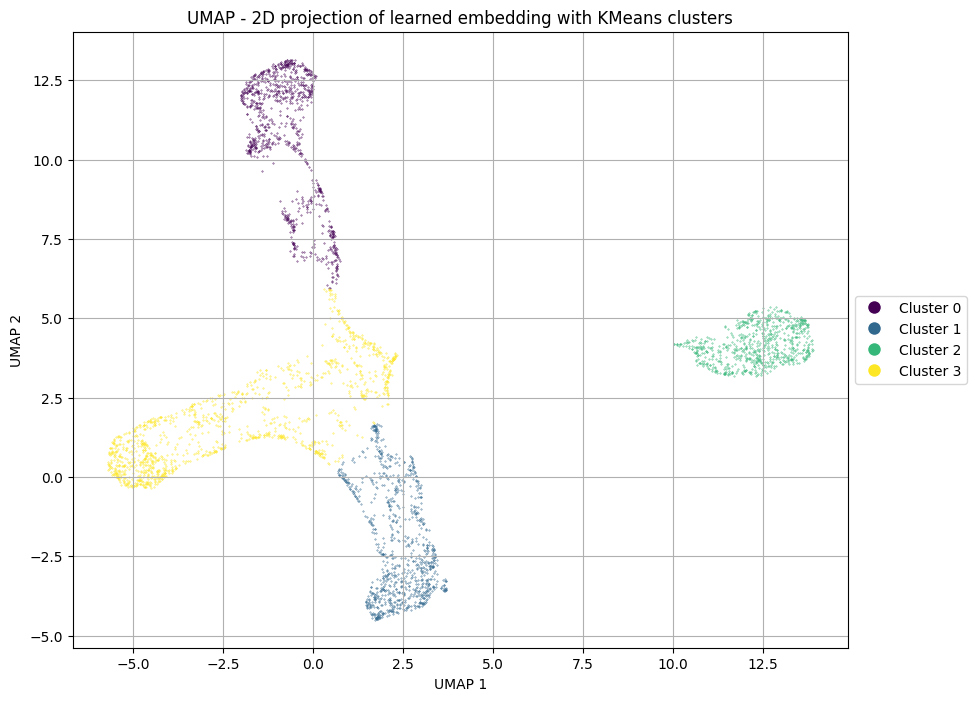

In [12]:
cluster_composition = get_clustering(X, Y, "mlp_umap_kmeans", mapping2, n_clusters=4)

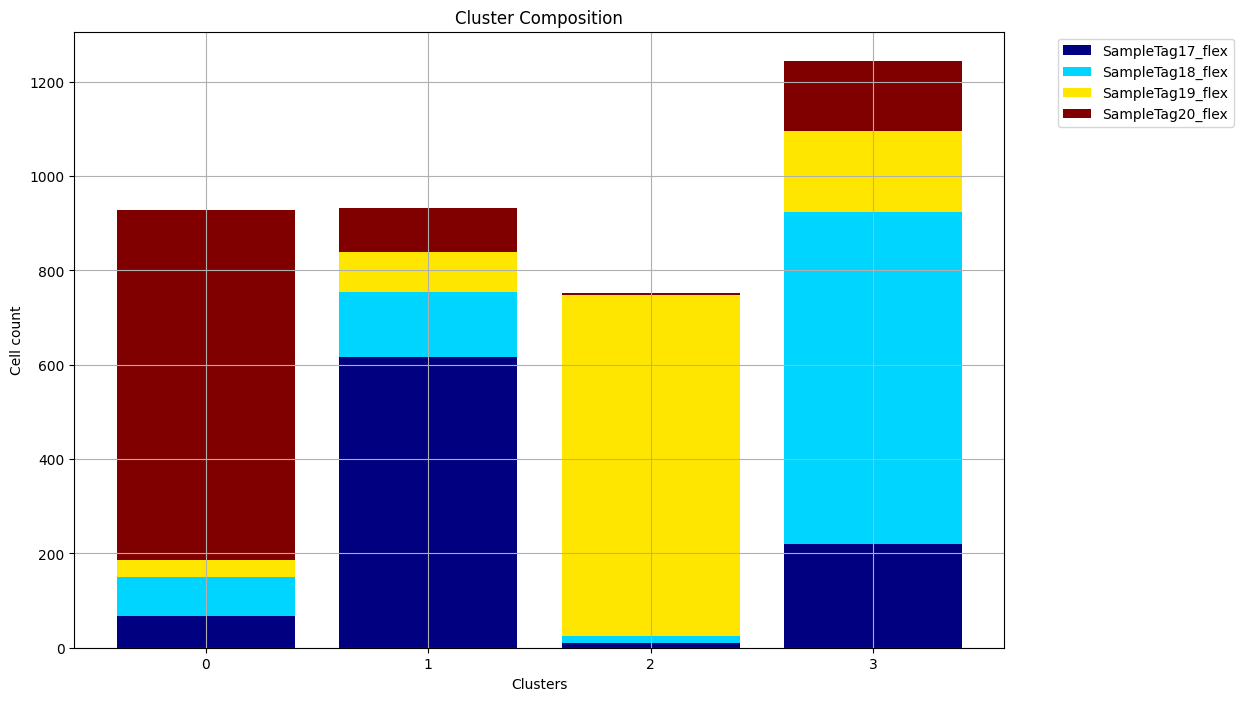

In [13]:
plot_cluster_composition(cluster_composition, 'mlp_cluster_composition')

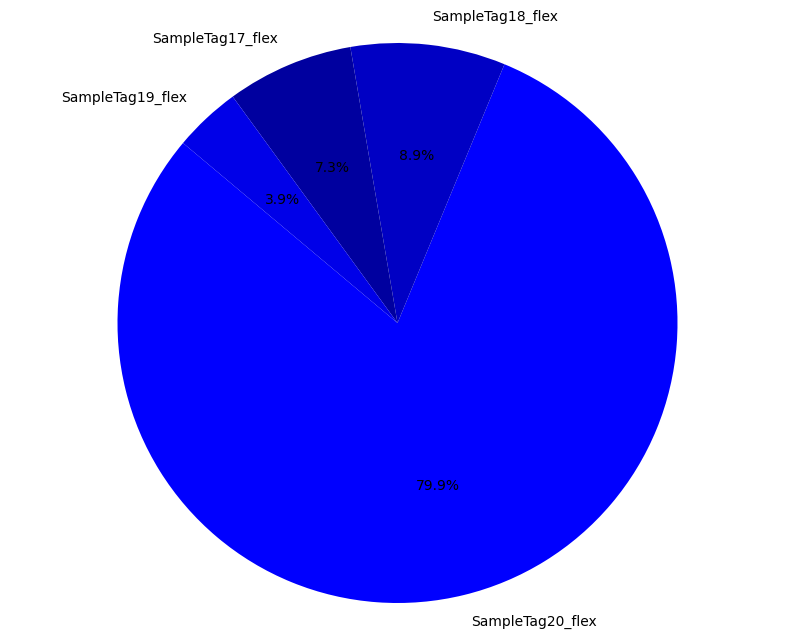

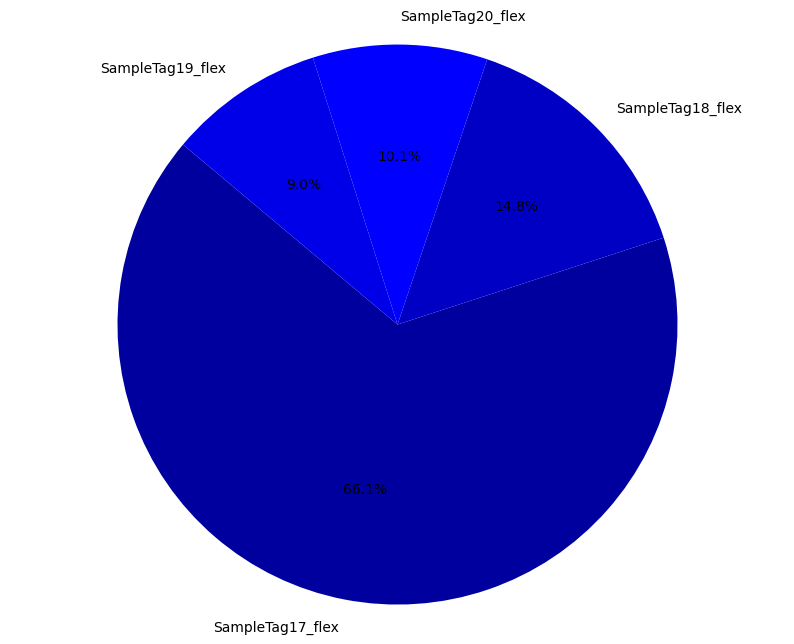

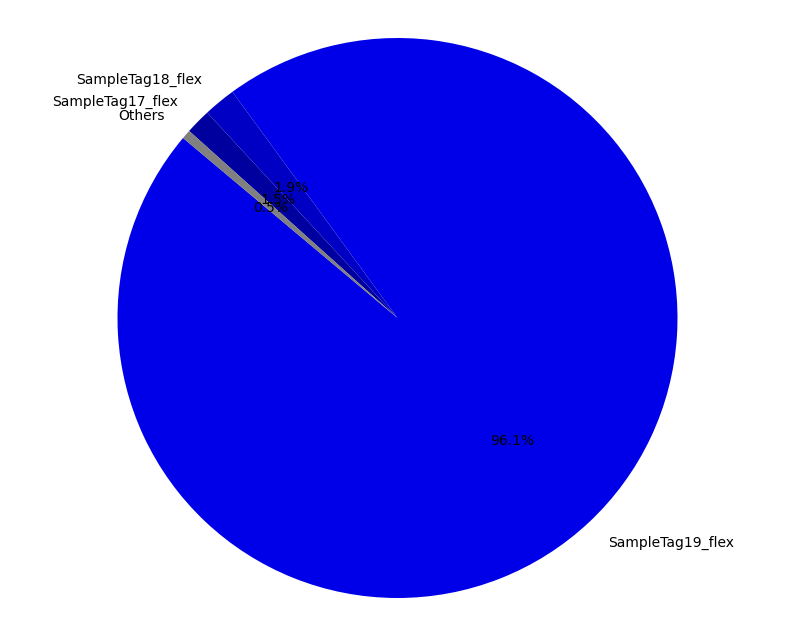

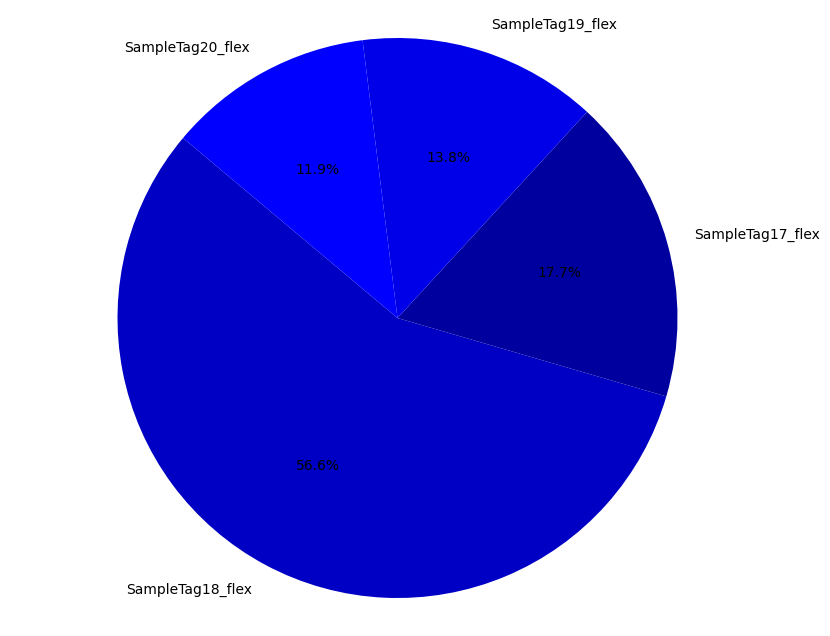

In [14]:
for i in range(len(cluster_composition)):
    get_pie_chart(cluster_composition, i, mapping2)

In [ ]:
from torch import nn
from modules.kan_model import DeepKAN
import torch
from matplotlib import pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
input_dim = 29535
shared_layers = [1024,256,32]
num_knots = 5
spline_order = 3
noise_scale = 0.1
base_scale = 1.0
spline_scale = 1.0
activation = nn.SiLU
grid_epsilon = 0.02
grid_range = [-1, 1]

In [ ]:
base_net = DeepKAN(input_dim, shared_layers, num_knots, spline_order,
                noise_scale, base_scale, spline_scale, activation, grid_epsilon, grid_range)

In [ ]:
model_path = "kan_0_5_32.pth"
checkpoint = torch.load(model_path, map_location=device)
base_net.load_state_dict(checkpoint)
base_net.to(device)

In [ ]:
# Prune the network
pruning_threshold = 0.01
base_net.prune_network(pruning_threshold)
mask = [(param != 0).float() for param in base_net.parameters()]
def apply_pruning_mask(model, mask):
    with torch.no_grad():
        for param, mask in zip(model.parameters(), mask):
            param.mul_(mask)
apply_pruning_mask(base_net, mask)

In [ ]:
def print_network_parameters(model):
    for i, layer in enumerate(model.layers):
        print(f"Layer {i + 1}:")
        print("Base Weights:")
        print(layer.base_weights.data)
        print("Spline Weights:")
        print(layer.spline_weights.data)
        if layer.standalone_spline_scaling:
            print("Spline Scales:")
            print(layer.spline_scales.data)
        print("-" * 50)

In [ ]:
print_network_parameters(base_net)

In [ ]:
plt.plot(base_net.layers[0].spline_weights[0][0].cpu().detach().numpy())